# Words in Space

Text analysis tasks like vectorization, document classification, and topic modeling require us to define what it means for any two documents to be similar. There are a number of different measures you can use to determine similarity for text (e.g. Minkowski, Cosine, Levenstein, Jaccard, etc.). In this post, we'll take a look a couple of these ways of measuring distance between documents in a specific corpus, and then visualize the result of our decisions on the distribution of the data.

## Words in Space: Introduction to Document Similarity for Text Analysis

While there are a number of different ways to quantify "distance" between documents (e.g. Minkowski, Cosine, Levenstein, Jaccard, etc.), fundamentally, each relies on our ability to imagine documents as points in space, where the relative closeness of any two is a measure of their similarity.

Nevertheless, our choice of distance metric is very important!

Why? Because text data:

 - is very high dimensional
 - is often sparsely distributed
 - has some features that are more important than others
 - has some feature variations matter more than others

So... in this post we'll experiment with a few different distance measures and visualize the results with t-distributed stochastic neighbor embedding, or t-SNE. Later on (or in a separate post) we'll also visualize feature importances and explore some feature distributions with dispersion plots.


## Load the corpus

In [1]:
import os

from sklearn.datasets.base import Bunch
from yellowbrick.download import download_all

## The path to the test data sets
FIXTURES  = os.path.join(os.getcwd(), "data")

## Dataset loading mechanisms
datasets = {
    "hobbies": os.path.join(FIXTURES, "hobbies")
}


def load_data(name, download=True):
    """
    Loads and wrangles the passed in text corpus by name.
    If download is specified, this method will download any missing files. 
    """
    
    # Get the path from the datasets 
    path = datasets[name]
    
    # Check if the data exists, otherwise download or raise 
    if not os.path.exists(path):
        if download:
            download_all() 
        else:
            raise ValueError((
                "'{}' dataset has not been downloaded, "
                "use the download.py module to fetch datasets"
            ).format(name))
    
    # Read the directories in the directory as the categories. 
    categories = [
        cat for cat in os.listdir(path) 
        if os.path.isdir(os.path.join(path, cat))
    ]
    
    files  = [] # holds the file names relative to the root 
    data   = [] # holds the text read from the file 
    target = [] # holds the string of the category 
        
    # Load the data from the files in the corpus 
    for cat in categories:
        for name in os.listdir(os.path.join(path, cat)):
            files.append(os.path.join(path, cat, name))
            target.append(cat)
            
            with open(os.path.join(path, cat, name), 'r') as f:
                data.append(f.read())
        
    
    # Return the data bunch for use similar to the newsgroups example
    return Bunch(
        categories=categories,
        files=files,
        data=data,
        target=target,
    )

corpus = load_data('hobbies')

# Vectorize the Documents

In [2]:
import matplotlib.pyplot as plt
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer()
docs       = vectorizer.fit_transform(corpus.data)
labels     = corpus.target


## About t-SNE

Scikit-learn implements this decomposition method as the `sklearn.manifold.TSNE` transformer. By decomposing high-dimensional document vectors into 2 dimensions using probability distributions from both the original dimensionality and the decomposed dimensionality, t-SNE is able to effectively cluster similar documents. By decomposing to 2 or 3 dimensions, the documents can be visualized with a scatter plot.

Unfortunately, TSNE is very expensive, so typically a simpler decomposition method such as SVD or PCA is applied ahead of time. In Yellowbrick, the `TSNEVisualizer` creates an inner transformer pipeline that applies such a decomposition first (SVD with 50 components by default), then performs the t-SNE embedding. The visualizer then plots the scatter plot, coloring by cluster or by class, or neither if a structural analysis is required.

### Squared Euclidean Distance
By default, `sklearn.manifold.TSNE` (and therefore also `TSNEVisualizer`) uses Euclidean distance, interpreted as squared Euclidean distance (in Scipy, this is "sqeuclidean").

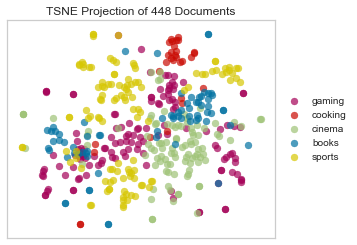

In [3]:
tsne = TSNEVisualizer()
tsne.fit(docs, labels)
tsne.poof()

### Euclidean Distance

Euclidean computes the distance between m points using 2-norm as the distance metric between the points. The points are arranged as m n-dimensional row vectors in the matrix X.

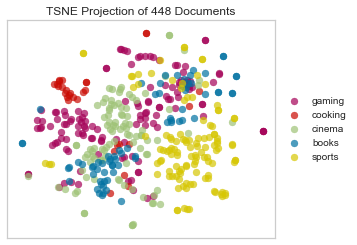

In [4]:
tsne = TSNEVisualizer(metric="euclidean")
tsne.fit(docs, labels)
tsne.poof()

As you've probably heard, [Euclidean distance is not an ideal choice for any sparse data](https://stats.stackexchange.com/questions/29627/euclidean-distance-is-usually-not-good-for-sparse-data/29647) (also [this](https://stats.stackexchange.com/questions/99171/why-is-euclidean-distance-not-a-good-metric-in-high-dimensions)). That's because when we vectorize a corpus, we end up with huge, sparse vectors. That means that it's sort of a crapshoot as to whether the most informative features (e.g. words) will vary in a way that will be captured by Euclidean distance. We can see in the above that Euclidean distance hasn't done a terrible job of spacially differentiating the different categories of documents; the "sports" and "cooking" clusters look pretty clear. However there's a lot of overlap and muddling of the other categories.

This makes more sense when we think in terms of informative features, which in the case of text are words. Some of the most informative features in the cooking category might occur only in a chunk of the corpus, others (maybe words from the "cinema" and "gaming" categories) might be spread out through the whole corpus, but more frequently in some documents than others. Some of our documents might be really long, while others are short, which means they'll be hard to compare; the short one will have a _much_ more sparse vector representation.

What to do?


## Distance Metrics for Non-numerical Inputs

Per [sklearn](http://scikit-learn.org/stable/faq.html#how-do-i-deal-with-string-data-or-trees-graphs):

"scikit-learn estimators assume you’ll feed them real-valued feature vectors. This assumption is hard-coded in pretty much all of the library. However, you can feed non-numerical inputs to estimators in several ways."

In our case, the `sklearn.manifold.TSNE` has a `metric` param that will allow us to leverage any of the [distance metrics](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html) available in Scipy!

We could try them all!

```
distance_functions = [
    "braycurtis", "canberra", "chebyshev", "cityblock", "correlation", "cosine", 
    "dice", "euclidean", "hamming", "jaccard", "kulsinski", "mahalanobis", 
    "matching", "minkowski", "rogerstanimoto", "russellrao", "seuclidean", 
    "sokalmichener", "sokalsneath", "sqeuclidean", "yule"
]

for metric in distance_functions:
    tsne = TSNEVisualizer(metric=metric)
    tsne.fit(docs, labels)
    tsne.poof()
   
```

... but some are a bit finicky, so let's walk through them all individually. 

We'll start to see pretty quickly that there are several that just don't make sense at all in the context of text data.

### Manhattan (aka "Taxicab" or "City Block") Distance

[Manhattan distance](https://en.wikipedia.org/wiki/Taxicab_geometry) between two points is computed as the sum of the absolute differences of their Cartesian coordinates.

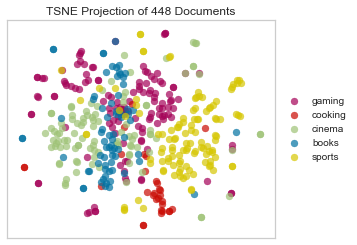

In [5]:
tsne = TSNEVisualizer(metric="cityblock")
tsne.fit(docs, labels)
tsne.poof()

### Minkowski Distance

Minkowski distance is a generalization of Euclidean and Manhattan distance, and defines the distance
between two points in a normalized vector space.

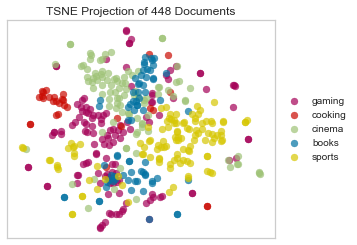

In [6]:
tsne = TSNEVisualizer(metric="minkowski")
tsne.fit(docs, labels)
tsne.poof()

### Bray Curtis Dissimilarity

[Bray–Curtis dissimilarity](https://en.wikipedia.org/wiki/Bray%E2%80%93Curtis_dissimilarity) is a statistic used to quantify the compositional dissimilarity between two different sites, based on counts at each site. The Bray–Curtis dissimilarity is bounded between 0 and 1, where 0 means the two sites have the same composition (that is they share all the species), and 1 means the two sites do not share any species. *Note: not technically a distance measure because it doesn't satisfy the [triangle inequality](https://en.wikipedia.org/wiki/Triangle_inequality).*

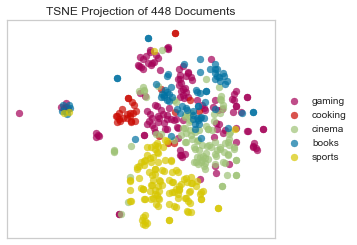

In [7]:
tsne = TSNEVisualizer(metric="braycurtis")
tsne.fit(docs, labels)
tsne.poof()

Note the weird beauty mark in the plot above. We'll see this in several of the plots below.



### Canberra Distance

[Canberra distance](https://en.wikipedia.org/wiki/Canberra_distance) is a numerical measure of the distance between pairs of points in a vector space. It is a weighted version of [Manhattan distance](https://en.wikipedia.org/wiki/Taxicab_geometry) and is sometimes used as a metric for comparing ranked lists and for intrusion detection in computer security. 

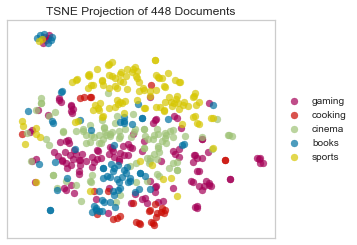

In [8]:
tsne = TSNEVisualizer(metric="canberra")
tsne.fit(docs, labels)
tsne.poof()

Another beauty mark!



### Chebyshev Distance

[Chebyshev distance](https://en.wikipedia.org/wiki/Chebyshev_distance) between two n-vectors u and v is the maximum norm-1 distance between their respective elements. 

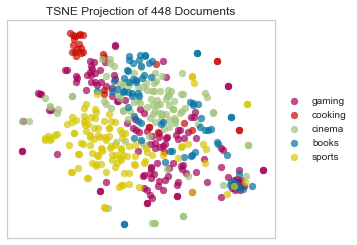

In [9]:
tsne = TSNEVisualizer(metric="chebyshev")
tsne.fit(docs, labels)
tsne.poof()

Chebyshev does seem to produce a beauty mark also, but it's less distinct from the rest of the points.



### Cosine Distance

We can also measure vector similarity with [cosine distance](https://en.wikipedia.org/wiki/Cosine_similarity), using the cosine of the angle between the two vectors to assess the degree to which they share the same orientation. In effect, the more parallel any two vectors are, the more similar the documents will be (regardless of their magnitude). Cosine distance is not *technically* a distance measure because it doesn't satisfy the [triangle inequality](https://en.wikipedia.org/wiki/Triangle_inequality). Nevertheless, cosine distance is often an excellent option for text data because it corrects for an variations in the length of the documents (since we're measuring the angle between vectors rather than their magnitudes). Moreover, it can be a very efficient way to compute distance with sparse vectors because it considers only the non-zero elements.

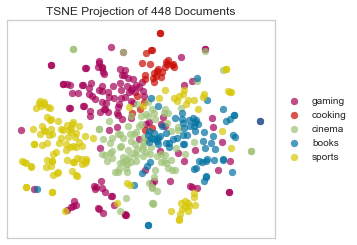

In [10]:
tsne = TSNEVisualizer(metric="cosine")
tsne.fit(docs, labels)
tsne.poof()

## Danger! 

There are also a *boatload* of distance metrics that make no sense at all for sparse, non-numeric data. 

Let's take a look!


### Jaccard Distance

[Jaccard distance](https://en.wikipedia.org/wiki/Jaccard_index) defines similarity between finite sets as the quotient of their intersection and their union. For instance, we could measure the Jaccard distance between two documents A and B by dividing the number of unique words that appear in both A and B by the total number of unique words that appear in A and B. A value of 0 would indicate that the two documents have nothing in common, a 1 that they were the same document, and values between 0 and 1 indicating their relative degree of similarity.

Jaccard distanceis actually *not* a bad metric for text distance, but it's much more effective for detecting things like [document duplication](https://moz.com/devblog/near-duplicate-detection/). It's much less helpful for finding more nuanced similarities and patterns.

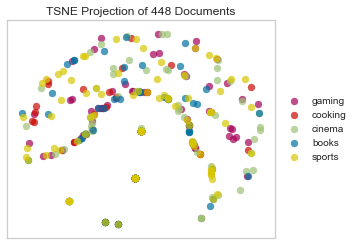

In [11]:
tsne = TSNEVisualizer(metric="jaccard")
tsne.fit(docs, labels)
tsne.poof()

Notice the crescent shape!



### Dice Dissimilarity

[Dice distance](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.dice.html) computes the [Dice dissimilarity](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) between two boolean 1-D arrays. It is similar to Jaccard distance.

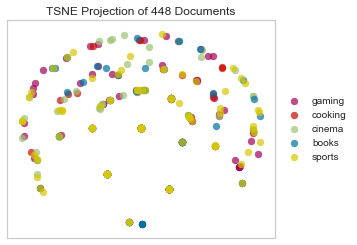

In [12]:
tsne = TSNEVisualizer(metric="dice")
tsne.fit(docs, labels)
tsne.poof()

Again we see the crescent shape we saw in Jaccard.


### Kulsinski Dissimilarity

Like Jaccard and Dice, [Kulsinski distance](https://en.wikipedia.org/wiki/Qualitative_variation#Kulczy%C5%84ski's_coefficient) is a set distance, computed as the [Kulsinski dissimilarity](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.spatial.distance.kulsinski.html) between two boolean 1-D arrays, in this case where nonzero entries are treated as True, zero entries are treated as False.

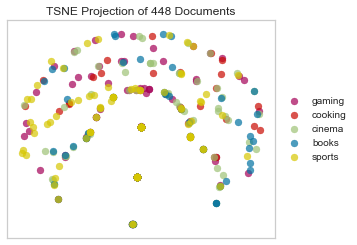

In [13]:
tsne = TSNEVisualizer(metric="kulsinski")
tsne.fit(docs, labels)
tsne.poof()

Another crescent!



### Russell-Rao Dissimilarity

Like the last few examples, [Russell-Rao dissimilarity](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.russellrao.html) quantifies the difference between two boolean 1-D arrays.

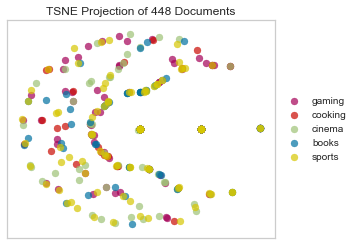

In [14]:
# russellrao
tsne = TSNEVisualizer(metric="russellrao")
tsne.fit(docs, labels)
tsne.poof()

Another crescent!



### Sokal Sneath Distance

Computes the [Sokal-Sneath distance](https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.spatial.distance.sokalsneath.html) between each pair of boolean vectors.

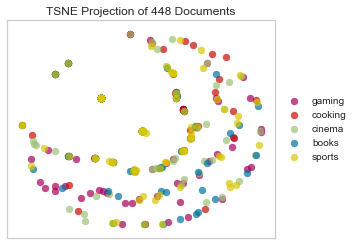

In [15]:
tsne = TSNEVisualizer(metric="sokalsneath")
tsne.fit(docs, labels)
tsne.poof()

### Sokal Michener

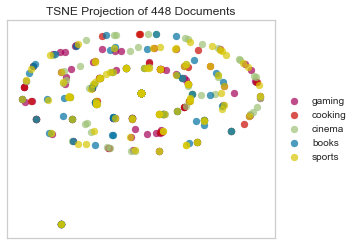

In [16]:
tsne = TSNEVisualizer(metric="sokalmichener")
tsne.fit(docs, labels)
tsne.poof()

### Rogers Tanimoto

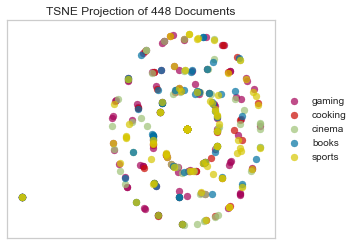

In [17]:
tsne = TSNEVisualizer(metric="rogerstanimoto")
tsne.fit(docs, labels)
tsne.poof()

### Hamming

[Hamming distance](https://en.wikipedia.org/wiki/Hamming_distance) between two strings of equal length is the number of positions at which the corresponding symbols are different. In other words, it measures the minimum number of substitutions required to change one string into the other, or the minimum number of errors that could have transformed one string into the other. In a more general context, the Hamming distance is one of several string metrics for measuring the edit distance between two sequences.

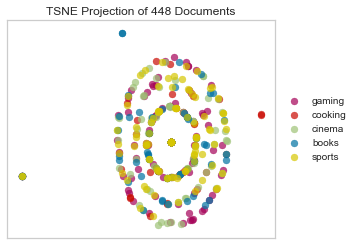

In [18]:
tsne = TSNEVisualizer(metric="hamming")
tsne.fit(docs, labels)
tsne.poof()

Hehe.


## Errors to Sort Out Later

### Correlation Coefficient Distance 

The correlation coefficient distance between vectors u and v.

In [19]:
# tsne = TSNEVisualizer(metric="correlation")
# tsne.fit(docs, labels)
# tsne.poof()

### Mahalanobis Distance

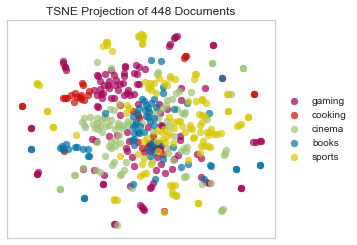

In [20]:
tsne = TSNEVisualizer(metric="mahalanobis", method='exact')
tsne.fit(docs, labels)
tsne.poof()

### Standardized Euclidean Distance

In [21]:
# tsne = TSNEVisualizer(metric="seuclidean")
# tsne.fit(docs, labels)
# tsne.poof()

### Yule

In [22]:
# tsne = TSNEVisualizer(metric="yule")
# tsne.fit(docs, labels)
# tsne.poof()

### Further Reading

 - [A Survey of Binary Similarity and Distance Measures](http://www.iiisci.org/journal/CV$/sci/pdfs/GS315JG.pdf)